# CheXScan DenseNet-121 Model

## Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader

from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

from PIL import Image

print("Imports completed successfully.")

Imports completed successfully.


## Run this code if you're using Colab

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

## Transform functions for data augmentation and normalization

You can further adjust these parameters if needed to achieve the desired balance between augmentation and maintaining image quality.

In [4]:
train_transform = transforms.Compose([   
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.03, hue=0.03),  # Adjust saturation and hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Summary

In [6]:
class_names = ['Normal', 'Pneumonia', 'Tuberculosis'] 

In [7]:
data_dir = r"D:/Jupyter/chexscan-folder/chexscan-experiment/data"
train_data_dir = os.path.join(data_dir, 'train_data')
test_data_dir = os.path.join(data_dir, 'test_data')

In [8]:
def count_images_in_subdirectories(directory):
    subdirectories = os.listdir(directory)
    counts = {}
    for subdir in subdirectories:
        subdir_path = os.path.join(directory, subdir)
        count = sum(len(files) for _, _, files in os.walk(subdir_path))
        counts[subdir] = count
    return counts

In [10]:
train_counts = count_images_in_subdirectories(train_data_dir)
test_counts = count_images_in_subdirectories(test_data_dir)

print("Number of images in each subdirectory of training data:")
for subdir, count in train_counts.items():
    print(f"{subdir}: {count}")

print("\nNumber of images in each subdirectory of testing data:")
for subdir, count in test_counts.items():
    print(f"{subdir}: {count}")

Number of images in each subdirectory of training data:
Normal: 80
Pneumonia: 80
Tuberculosis: 80

Number of images in each subdirectory of testing data:
Normal: 20
Pneumonia: 20
Tuberculosis: 20


## Define datasets (Online)

In [11]:
# data_dir = '/content/drive/My Drive/THESIS/Datasets/Mary/'
# train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
# test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define datasets (Local)

In [12]:
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train_data'), transform=train_transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test_data'), transform=test_transform)

## Define data loaders

In [13]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

## Visualizes training data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

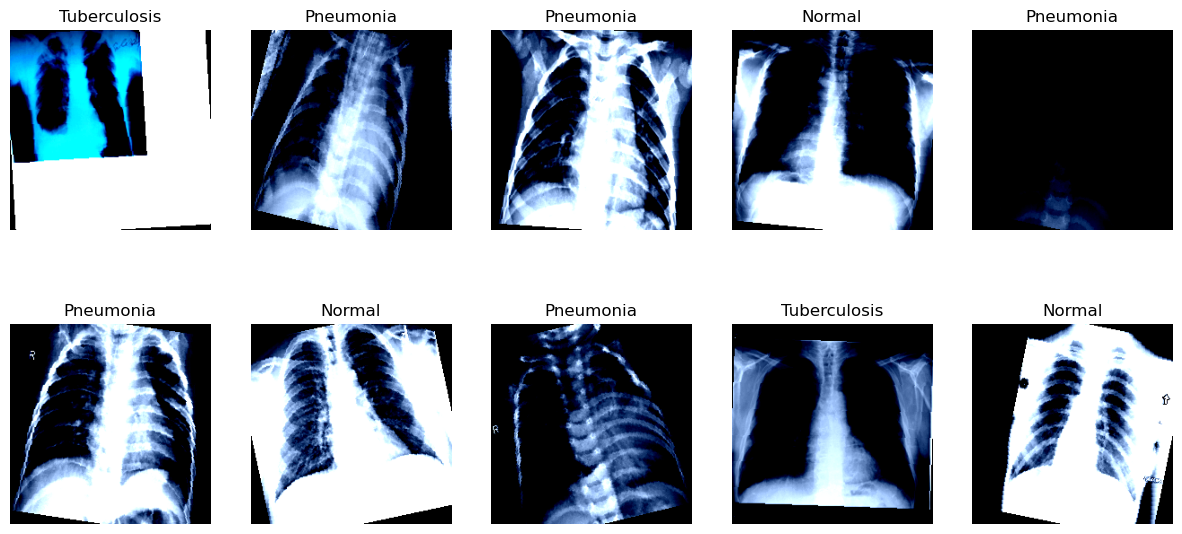

In [14]:
def visualize_training_data(loader):
    
    """
    Visualizes a batch of training images along with their corresponding labels.

    Parameters:
        loader (DataLoader): DataLoader containing the training dataset.

    Returns:
        None
    """
    
    classes = loader.dataset.classes
    class_names = {i: classes[i] for i in range(len(classes))}
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(figsize=(15, 7), ncols=5, nrows=2)
    for i, ax in enumerate(axes.flat):
        image = images[i].permute(1, 2, 0)
        ax.imshow(image)
        ax.set_title(class_names[labels[i].item()])
        ax.axis('off')
    plt.show()

visualize_training_data(train_loader)

## Define DenseNet-121 model

In [15]:
model = models.densenet121(pretrained=True)

D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
# Modify the last layer of the classifier
num_classes = 3  # Replace 3 with the number of classes in your dataset
in_features = model.classifier.in_features
model.classifier = nn.Linear(in_features, num_classes)

## Define loss function and optimizer

In [18]:
criterion = nn.CrossEntropyLoss()

## Move model to GPU if available

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

## DenseNet-121 Model Training

In [20]:
learning_rates = [0.001, 0.0001]
best_params = {'learning_rate': None, 'validation_accuracy': 0.0}
early_stopping_patience = 2  # Number of epochs to wait before early stopping
best_val_accuracy = 0.0
best_epoch = 0

In [22]:
for lr in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Define training parameters
    num_epochs = 2  # Increased number of epochs for potential early stopping
    train_losses = []
    val_losses = []
    val_accuracies = []
    patience_counter = 0  # Counter for early stopping

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            # Calculate train accuracy
            _, predicted_train = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

        epoch_loss = running_loss / len(train_data)
        train_losses.append(epoch_loss)

        # Calculate train accuracy for the epoch
        accuracy_train = correct_train / total_train

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted_val = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()

        val_loss /= len(test_data)
        accuracy_val = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(accuracy_val)

        # Update the learning rate
        scheduler.step()

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'LR: {scheduler.get_lr()[0]:.5f}, '
              f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy_train:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy_val:.4f}')

        # Early stopping condition
        if accuracy_val > best_val_accuracy:
            best_val_accuracy = accuracy_val
            best_epoch = epoch + 1
            best_params['learning_rate'] = lr
            best_params['validation_accuracy'] = accuracy_val
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered!")
                break  # Break out of the loop if early stopping condition is met

print(f'Best parameters found: {best_params} at epoch {best_epoch}')

D:\Anaconda\Lib\site-packages\torch\optim\lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch [1/2], LR: 0.00100, Train Loss: 0.7754, Train Accuracy: 0.7667, Val Loss: 0.6965, Val Accuracy: 0.7333
Epoch [2/2], LR: 0.00100, Train Loss: 0.6363, Train Accuracy: 0.7958, Val Loss: 0.5098, Val Accuracy: 0.9500
Epoch [1/2], LR: 0.00010, Train Loss: 0.5446, Train Accuracy: 0.8500, Val Loss: 0.4806, Val Accuracy: 0.9333
Epoch [2/2], LR: 0.00010, Train Loss: 0.5304, Train Accuracy: 0.8917, Val Loss: 0.4649, Val Accuracy: 0.9667
Best parameters found: {'learning_rate': 0.0001, 'validation_accuracy': 0.9666666666666667} at epoch 2


## DenseNet-121 Model Training

In [ ]:
# Train the final model using the best parameters
best_lr = best_params['learning_rate']
optimizer = optim.Adam(model.parameters(), lr=best_lr)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Define training parameters
final_num_epochs = best_epoch  # Train for the number of epochs where early stopping was triggered
final_train_losses = []
final_val_losses = []
final_val_accuracies = []

# Training loop
for epoch in range(final_num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # Calculate train accuracy
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()

    epoch_loss = running_loss / len(train_data)
    final_train_losses.append(epoch_loss)

    # Calculate train accuracy for the epoch
    accuracy_train = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

    val_loss /= len(test_data)
    accuracy_val = correct_val / total_val
    final_val_losses.append(val_loss)
    final_val_accuracies.append(accuracy_val)

    # Update the learning rate
    scheduler.step()

    print(f'Epoch [{epoch + 1}/{final_num_epochs}], '
          f'LR: {scheduler.get_lr()[0]:.5f}, '
          f'Train Loss: {epoch_loss:.4f}, Train Accuracy: {accuracy_train:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy_val:.4f}')

## Training and Validation Loss

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(final_train_losses, label='Training Loss')
plt.plot(final_val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(final_val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Classification Report

In [ ]:
test_labels = []
predictions = []

# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())  # Append predictions
        test_labels.extend(labels.cpu().numpy())  # Append test labels

# Convert validation labels and predictions to numpy arrays
y_true = np.array(test_labels)
y_pred = np.array(predictions)

# Generate classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

## Confusion Matrix

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False, xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Saving the model

In [ ]:
torch.save(model.state_dict(), 'final_densenet121_model_01.pth')
print("Final model saved successfully!")